# Práctica 1: Aprendizaje automático

__Fecha de entrega: 13 de marzo de 2022__

El objetivo de esta práctica es aplicar los distintos algoritmos de aprendizaje automático disponibles en la scikit-learn [sklearn](https://scikit-learn.org/stable/) sobre varios conjuntos de datos y aprender a interpretar los resultados obtenidos. La práctica consta de 3 notebooks que se entregarán simultáneamente en la tarea de entrega habilitada en el Campus  Virtual.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

# Apartado 1: Clustering

__Número de grupo: 15__

__Nombres de los estudiantes: Javier Sande Ríos y Mario Sanz Guerrero__

## 1) Carga del conjunto de datos

Crea un dataframe a partir del fichero `prestamos.csv` que se proporciona junto con la práctica. 

El conjunto de datos contiene por cada fila los datos de un préstamo que fue concedido por una empresa de crédito p2p. Las variables que caracterizan el préstamo son las siguientes:
  - `loan_amnt` es la cantidad de dinero solicitada en dólares
  - `purpose` es el propósito para el que se solicitó el préstamo
  - `revenue` son los ingresos anuales en dólares de la persona que solicitó el préstamos
  - `dti_n` es el porcentaje de endeudamiento sobre los ingresos anuales de la persona que solicitó el préstamo
  - `fico_n` se trata de un indicador de solvencia de la persona que solicitó el préstamo. A mayor puntuación, mayor solvencia, y además se cuenta con estos rangos orientativos:
    - 300-550: Pobre
    - 550-620: Subprime (alto riesgo)
    - 620-680: Crédito aceptable
    - 680-740: Buen crédito
    - 740-850: Excelente crédito

  -`home_ownership_n` es una variable categórica que indica la situación de vivienda en la que vive la persona solicitante
    - `OWN` es en propiedad
    - `MORTAGAGE` indica que está hipotecada
    - `RENT` indica que vive en alquiler
    - `OTHER` es una categoría que agrega otras posibilidades

- `emp_length` es una variable ordinal, no es estrictamente numérica, ya que el valor 0 denota que no consta información, los valores entre 1 y 10 indican una permanencia inferior a X años, y el valor 11 indica una permanencia superior a 10 años.
- `Default` es la variable que usaremos como **variable objetivo** del conjunto de datos e indica si la persona incumplió (incurrió en *default*) o no el préstamo.


Como pandas no tiene forma de saber que las variables `home_ownership_n`, `purpose`, `emp_length` y `Default` son en realidad categóricas, debes indicárselo tú.

#### Solución:

In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv('prestamos.csv')

numberColumns = ["loan_amnt","revenue", "dti_n", "fico_n"]
categoryColumns = ["purpose", "home_ownership_n", "emp_length_n", "Default"]

df[categoryColumns] = df[categoryColumns].astype("category")
df

,loan_amnt,purpose,revenue,dti_n,fico_n,home_ownership_n,emp_length_n,Default
0,32000,car,135000.000,18.930,687.000,MORTGAGE,1,0
1,32000,car,90000.000,9.290,822.000,MORTGAGE,10,1
2,30000,car,95000.000,1.340,722.000,RENT,11,0
3,25750,car,230000.000,6.420,747.000,MORTGAGE,11,0
4,25200,car,72000.000,30.950,692.000,OWN,11,0
...,...,...,...,...,...,...,...,...
13789,1275,vacation,42000.000,31.890,792.000,RENT,0,0
13790,1200,vacation,36000.000,12.270,747.000,MORTGAGE,8,0
13791,1000,vacation,76000.000,25.260,702.000,MORTGAGE,11,0
13792,1000,vacation,32000.000,17.700,747.000,MORTGAGE,0,0


Del dataframe anterior, vamos a crear dos dataframes nuevos: uno que solo tenga variables numéricas y otro que solo tenga variables categóricas.

In [3]:
df_num = df[numberColumns]
df_num

,loan_amnt,revenue,dti_n,fico_n
0,32000,135000.000,18.930,687.000
1,32000,90000.000,9.290,822.000
2,30000,95000.000,1.340,722.000
3,25750,230000.000,6.420,747.000
4,25200,72000.000,30.950,692.000
...,...,...,...,...
13789,1275,42000.000,31.890,792.000
13790,1200,36000.000,12.270,747.000
13791,1000,76000.000,25.260,702.000
13792,1000,32000.000,17.700,747.000


In [4]:
df_cat = df[categoryColumns]
df_cat

,purpose,home_ownership_n,emp_length_n,Default
0,car,MORTGAGE,1,0
1,car,MORTGAGE,10,1
2,car,RENT,11,0
3,car,MORTGAGE,11,0
4,car,OWN,11,0
...,...,...,...,...
13789,vacation,RENT,0,0
13790,vacation,MORTGAGE,8,0
13791,vacation,MORTGAGE,11,0
13792,vacation,MORTGAGE,0,0


## 2) Análisis de los datos

### 2.1) Numéricos

Analiza razonadamente las distribuciones de cada una de las variables numéricas (medias, desviaciones típicas, rangos, ...) y las principales relaciones entre pares de variables (diagrama de dispersión, coeficientes de correlación, ...).

#### Solución:

**Variables numéricas: Análisis**

In [5]:
df.describe(include=np.number).transpose()

,count,mean,std,min,25%,50%,75%,max
loan_amnt,13794.000,14507.833,9037.938,1000.000,7300.000,12000.000,20000.000,40000.000
revenue,13794.000,79737.300,56463.580,7000.000,48000.000,68000.000,97000.000,1650000.000
dti_n,13794.000,18.825,9.796,0.000,12.200,18.085,24.758,190.870
fico_n,13794.000,699.107,32.826,662.000,672.000,692.000,717.000,847.500


**Loan amount:** Esta variable indica la cantidad del préstamo. La media se sitúa en los 14.507,83€ pero la desviación típica es muy alta (9.037,93€), por lo que la media no es muy representativa del conjunto de datos, y los valores varían desde los 1.000€ hasta los 40.000€. Además, teniendo en cuenta el siguiente cambio de percentiles:

- De _min_ a _25%_: x7.3
- De _25%_ a _50%_: x1.64
- De _50%_ a _75%_: x1.66
- De _75%_ a _max_: x2

podemos decir que la mayor cantidad de préstamos se corresponderán con los valores del primer y segundo percentil (25% y 50%) ya que son los que menor cambio de valor tienen, por ello, mayor cantidad de préstamos en ellos. Es decir, que la mayoría de préstamos oscilarán entre los 7.300€ y los 12.000€, aproximadamente.

**Revenue:** Esta variable indica los ingresos de la persona que solicitó el préstamo. La media se sitúa en los 79.737,3€ pero la desviación típica es muy alta (la media no será representativa) y los valores se encuentran en un rango que va desde los 7.000€ hasta los 1.650.000€. Teniendo en cuenta que el percentil del 50% es menor que la media, la distribución estará sesgada a la izquierda.

**Dti_n:** Esta variable indica el porcentaje de endeudamiento sobre los ingresos anuales de la persona que solicitó el préstamo. La media es de 18.82%, y teniendo en cuenta que el percentil del 50% está en el valor de 18.08, podemos decir que los valores están distribuidos uniformemente. Sin embargo, la desviación típica es bastante elevada, por lo que la media no es muy representativa sobre el conjunto de datos.

**Fico_n:** Esta variable es un indicador de solvencia de la persona que solicitó el préstamo. El valor de este indicador puede ir desde 300 (solicitantes más pobres) hasta los 850 (los solicitantes con un excelente crédito). En los datos de entrada solo contamos con solicitantes con un ídice superior a 662 (buen crédito). La media se sitúa en 699.107 y la desviación típica es relativamente baja (32.826). Teniendo en cuenta que el percentil del 50% es bastante menor que la media considerando la leve variación de los datos, la distribución estará muy sesgada a la izquierda.

**Diagrama de dispersión: Análisis**

array([[<AxesSubplot:xlabel='loan_amnt', ylabel='loan_amnt'>,
        <AxesSubplot:xlabel='revenue', ylabel='loan_amnt'>,
        <AxesSubplot:xlabel='dti_n', ylabel='loan_amnt'>,
        <AxesSubplot:xlabel='fico_n', ylabel='loan_amnt'>],
       [<AxesSubplot:xlabel='loan_amnt', ylabel='revenue'>,
        <AxesSubplot:xlabel='revenue', ylabel='revenue'>,
        <AxesSubplot:xlabel='dti_n', ylabel='revenue'>,
        <AxesSubplot:xlabel='fico_n', ylabel='revenue'>],
       [<AxesSubplot:xlabel='loan_amnt', ylabel='dti_n'>,
        <AxesSubplot:xlabel='revenue', ylabel='dti_n'>,
        <AxesSubplot:xlabel='dti_n', ylabel='dti_n'>,
        <AxesSubplot:xlabel='fico_n', ylabel='dti_n'>],
       [<AxesSubplot:xlabel='loan_amnt', ylabel='fico_n'>,
        <AxesSubplot:xlabel='revenue', ylabel='fico_n'>,
        <AxesSubplot:xlabel='dti_n', ylabel='fico_n'>,
        <AxesSubplot:xlabel='fico_n', ylabel='fico_n'>]], dtype=object)

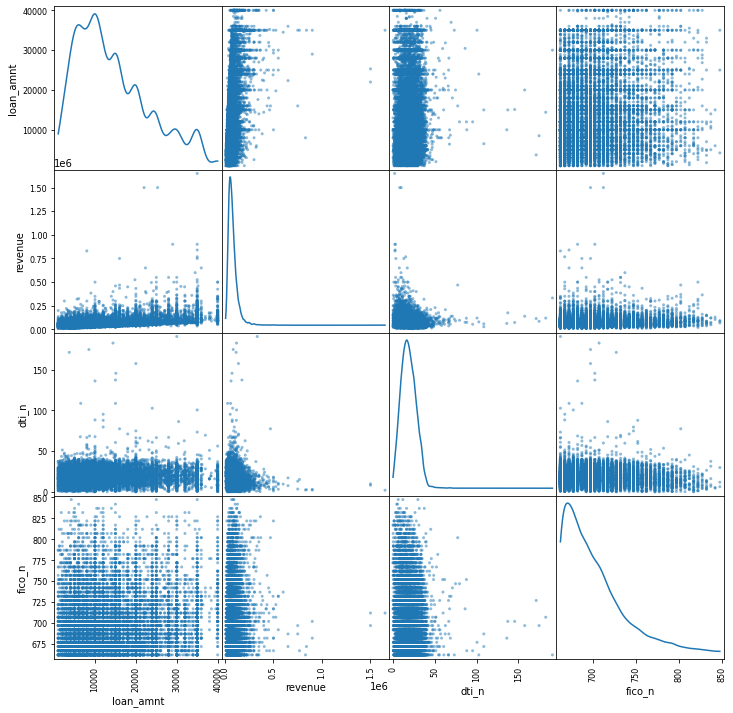

In [6]:
from pandas.plotting import scatter_matrix
%matplotlib inline

scatter_matrix(df_num, figsize = (12, 12), diagonal = 'kde')

Como vemos, en este diagrama de dispersión vemos valores muy alejados de la media que dificultan la visualización y el estudio de los resultados. Por ello, vamos a volver a dibujar el diagrama de dispersión pero retirando los valores que se vayan mucho de la media, que son los que producen ruido en el resultado. De esta forma podremos ver mucho más claras las relaciones entre pares de variables.

array([[<AxesSubplot:xlabel='loan_amnt', ylabel='loan_amnt'>,
        <AxesSubplot:xlabel='revenue', ylabel='loan_amnt'>,
        <AxesSubplot:xlabel='dti_n', ylabel='loan_amnt'>,
        <AxesSubplot:xlabel='fico_n', ylabel='loan_amnt'>],
       [<AxesSubplot:xlabel='loan_amnt', ylabel='revenue'>,
        <AxesSubplot:xlabel='revenue', ylabel='revenue'>,
        <AxesSubplot:xlabel='dti_n', ylabel='revenue'>,
        <AxesSubplot:xlabel='fico_n', ylabel='revenue'>],
       [<AxesSubplot:xlabel='loan_amnt', ylabel='dti_n'>,
        <AxesSubplot:xlabel='revenue', ylabel='dti_n'>,
        <AxesSubplot:xlabel='dti_n', ylabel='dti_n'>,
        <AxesSubplot:xlabel='fico_n', ylabel='dti_n'>],
       [<AxesSubplot:xlabel='loan_amnt', ylabel='fico_n'>,
        <AxesSubplot:xlabel='revenue', ylabel='fico_n'>,
        <AxesSubplot:xlabel='dti_n', ylabel='fico_n'>,
        <AxesSubplot:xlabel='fico_n', ylabel='fico_n'>]], dtype=object)

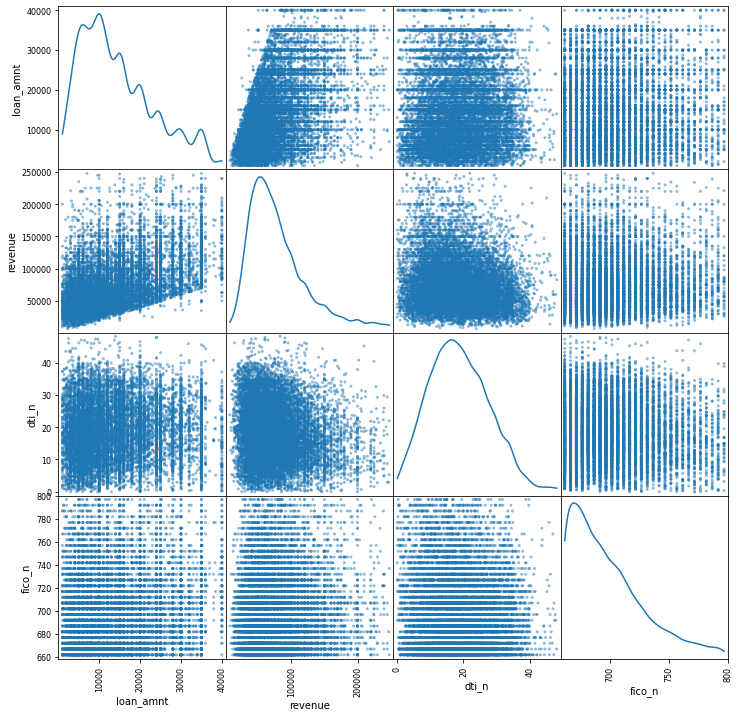

In [7]:
from pandas.plotting import scatter_matrix
%matplotlib inline

scatter_matrix(df_num[np.abs(df_num-df_num.mean()) <= (3*df_num).std()], figsize = (12, 12), diagonal = 'kde')

Una vez hemos quitado valores extremos que producían ruido, se facilita mucho el estudio de los resultados.

Lo más llamativo que vemos es la relación directamente proporcional que se produce entre la cantidad de dinero solicitada en el préstamo (`loan_amnt`) y los ingresos anuales del solicitante del préstamo (`revenue`). Esto indica que, por lo general, cuanto mayor es el sueldo anual de una persona, mayor es la cantidad de dinero que solicita. Sin embargo, la gran mayoría de los valores se concentran en rangos en los que ambas variables tienden a ser más baja. Es decir, que la mayoría de prestamos solicitados se producen por personas de ingresos tirando a bajos y por una cantidad de dinero solicitada también tirando a baja.

En el resto de variables no vemos una relación clara ya que los valores están bastante dispersos. A priori esto podría verse como algo negativo, pero realmente esta ausencia de relación nos da mucha información útil para la posterior agrupación de los datos.

A continuación vamos a desarrollar una función que va a predecir la mejor distribución de los datos teniendo en cuenta los datos de las distribuciones obtenidas en el anterior diagrama de dispersión. A esta función le vamos a poder meter las distribuciones que queramos que pueda predecir en el array `dist_names`. En nuestro caso le meteremos las distribuciones _Normal (Gaussiana)_, _Log Normal_, _Gamma_, y _Chi-Squared_, ya que son las que, a primera vista de los resultados, más información nos pueden aportar.

In [8]:
import scipy.stats as st
def get_best_distribution(data):
    dist_names = ["norm", "lognorm", "gamma", "chi2"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

In [9]:
for key in numberColumns:
    print(key)
    get_best_distribution(df[key].to_numpy())
    print('\n')

loan_amnt
Best fitting distribution: gamma
Best p value: 4.361859152881322e-28
Parameters for the best fit: (2.198000117878399, 392.57297778252104, 6421.86504793697)


revenue
Best fitting distribution: norm
Best p value: 1.3239906232321627e-254
Parameters for the best fit: (79737.29950703205, 56461.533183424566)


dti_n
Best fitting distribution: lognorm
Best p value: 6.734937978655832e-07
Parameters for the best fit: (0.244928492591304, -18.951864896589967, 36.6354915780869)


fico_n
Best fitting distribution: lognorm
Best p value: 1.171873381454531e-121
Parameters for the best fit: (1.2921101351043642, 661.1179767269482, 25.042074140967884)




Como vemos en los resultados obtenidos, las distribuciones que mejor ajustan a cada conjunto de datos son:

| **Datos**       | **Distribución** |
|-----------------|------------------|
| **`loan_amnt`** | Gamma            |
| **`revenue`**   | Normal           |
| **`dti_n`**     | Log Normal       |
| **`fico_n`**    | Log Normal       |

**Correlación entre pares de variables: Análisis**

In [10]:
df.corr()

,loan_amnt,revenue,dti_n,fico_n
loan_amnt,1.000,0.424,0.034,0.091
revenue,0.424,1.000,-0.138,0.091
dti_n,0.034,-0.138,1.000,-0.058
fico_n,0.091,0.091,-0.058,1.000


Como ya habíamos visto en el análisis del diagrama de dispersión, la relación más fuerte que se ve entre todos los pares de variables es entre las variables `loan_amnt` y `revenue`. Esta correlación es directamente proporcional, lo que indica que, de forma general, a mayor cantidad de préstamo, mayores son los ingresos anuales del solicitante.

La siguiente correlación más importante aunque con mucha diferencia con respecto a la anterior es la correlación inversamente proporcional entre las variables `revenue` y `dti_n`. Al ser inversamente proporcional, indica que una mayor cantidad de ingresos supone, por lo general, un menor porcentaje de endeudamiento del solicitante.


### 2.2) Categóricos

Analiza razonadamente las distribuciones de los valores de las variables categóricas incluyendo un diagrama de frecuencias y comentando lo más destacable.

#### Solución:

<AxesSubplot:>

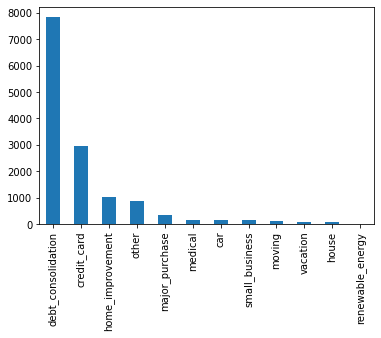

In [11]:
df_cat['purpose'].value_counts().plot.bar()

In [12]:
df_cat.groupby('purpose').describe()

home_ownership_n                        emp_length_n  \
                              count unique       top  freq        count   
purpose                                                                   
car                             154      3      RENT    70          154   
credit_card                    2960      4  MORTGAGE  1398         2960   
debt_consolidation             7841      4  MORTGAGE  3902         7841   
home_improvement               1016      3  MORTGAGE   769         1016   
house                            70      3      RENT    31           70   
major_purchase                  337      3  MORTGAGE   147          337   
medical                         163      3  MORTGAGE    74          163   
moving                          124      3      RENT    83          124   
other                           883      3      RENT   419          883   
renewable_energy                 13      3      RENT     8           13   
small_business                  145      3  MORTGAGE    69          145   
vacation                         88      3  MORTGAGE    39           88   

                                    Default                   
                   unique top  freq   count unique top  freq  
purpose                                                       
car                    12  11    48     154      2   0   125  
credit_card            12  11   879    2960      2   0  2422  
debt_consolidation     12  11  2720    7841      2   0  5983  
home_improvement       12  11   393    1016      2   0   833  
house                  11  11    26      70      2   0    50  
major_purchase         12  11   108     337      2   0   273  
medical                12  11    50     163      2   0   130  
moving                 11  11    29     124      2   0    99  
other                  12  11   285     883      2   0   689  
renewable_energy        7  11     5      13      2   0     9  
small_business         12  11    38     145      2   0    95  
vacation               12  11    31      88      2   0    77

<AxesSubplot:>

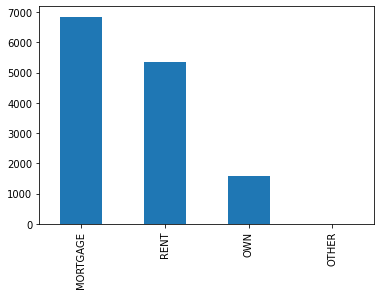

In [13]:
df_cat['home_ownership_n'].value_counts().plot.bar()

In [14]:
df_cat.groupby('home_ownership_n').describe()

purpose                                  emp_length_n         \
                   count unique                 top  freq        count unique   
home_ownership_n                                                                
MORTGAGE            6850     12  debt_consolidation  3902         6850     12   
OTHER                  9      2  debt_consolidation     8            9      6   
OWN                 1586     12  debt_consolidation   807         1586     12   
RENT                5349     12  debt_consolidation  3124         5349     12   

                           Default                   
                 top  freq   count unique top  freq  
home_ownership_n                                     
MORTGAGE          11  2751    6850      2   0  5576  
OTHER              4     2       9      2   0     7  
OWN               11   548    1586      2   0  1233  
RENT              11  1313    5349      2   0  3969

<AxesSubplot:>

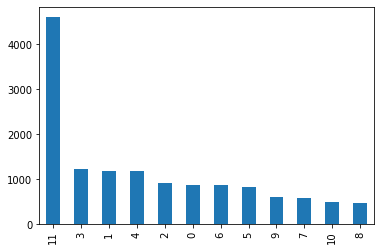

In [15]:
df_cat['emp_length_n'].value_counts().plot.bar()

In [16]:
df_cat.groupby('emp_length_n').describe()

purpose                                  home_ownership_n         \
               count unique                 top  freq            count unique   
emp_length_n                                                                    
0                875     11  debt_consolidation   476              875      3   
1               1174     12  debt_consolidation   656             1174      4   
2                909     12  debt_consolidation   503              909      3   
3               1232     12  debt_consolidation   700             1232      3   
4               1174     12  debt_consolidation   650             1174      4   
5                815     11  debt_consolidation   467              815      4   
6                860     11  debt_consolidation   462              860      4   
7                580     12  debt_consolidation   318              580      4   
8                470     11  debt_consolidation   257              470      4   
9                599     11  debt_consolidation   350              599      3   
10               494     10  debt_consolidation   282              494      3   
11              4612     12  debt_consolidation  2720             4612      3   

                             Default                   
                   top  freq   count unique top  freq  
emp_length_n                                           
0             MORTGAGE   398     875      2   0   615  
1                 RENT   594    1174      2   0   915  
2                 RENT   459     909      2   0   698  
3                 RENT   586    1232      2   0   967  
4                 RENT   535    1174      2   0   941  
5             MORTGAGE   378     815      2   0   638  
6             MORTGAGE   400     860      2   0   663  
7             MORTGAGE   283     580      2   0   443  
8             MORTGAGE   231     470      2   0   375  
9             MORTGAGE   300     599      2   0   476  
10            MORTGAGE   264     494      2   0   398  
11            MORTGAGE  2751    4612      2   0  3656

<AxesSubplot:>

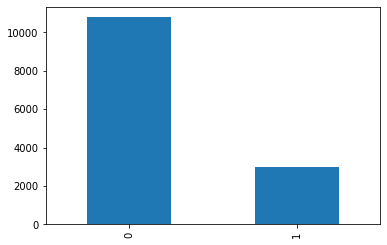

In [17]:
df_cat['Default'].value_counts().plot.bar()

In [18]:
df_cat.groupby('Default').describe()

purpose                                  home_ownership_n         \
          count unique                 top  freq            count unique   
Default                                                                    
0         10785     12  debt_consolidation  5983            10785      4   
1          3009     12  debt_consolidation  1858             3009      4   

                        emp_length_n                   
              top  freq        count unique top  freq  
Default                                                
0        MORTGAGE  5576        10785     12  11  3656  
1            RENT  1380         3009     12  11   956

**Variables categóricas: Análisis**

**Purpose:** Indica el motivo de la solicitud del préstamo. Como podemos observar, la gran mayoría son solicitados para consolidar deudas o para tarjetas de crédito, teniendo mucha más relevancia la primera.

**Home ownership:** Indica la situación de la vivienda en la que vive el solicitante. La gran mayoría de los préstamos se producen por personas que tienen la vivienda hipotecada o de alquiler. Viendo el resultado de la variable anterior (`purpose`), tiene sentido que muchos de los solicitantes estén en vivienda hipotecada teniendo en cuenta el alto número de préstamos solicitados para consolidar deudas. Podemos predecir que muchos de estos préstamos irán destinados a cubrir la deuda hipotecaria.

**Emp length:** Indica la permanencia del préstamo. La gran mayoría de los datos están en una permanencia mayor a 10 años. Tiene sentido este resultado considerando el alto número predecido de personas que tienen su deuda hipotecaria por pagar, teniendo en cuenta que las deudas hipotecarias suelen durar más de 10 años.

**Default:** Indica si una persona cumplió el préstamo (1) o si incumplió su pago (0). Como podemos ver, la gran mayoría de gente sí que cumple el préstamo, devolviendo la totalidad del dinero solicitado.

## 3) Preprocesar los datos

Para el clustering vamos a trabajar solamente con las variables verdaderamente numéricas. Crea un nuevo dataframe que sólo contenga las variables `loan_amnt`, `revenue`, `dti_n` y `fico_n`.

Teniendo en cuenta que vamos a utilizar el algoritmo k-Means para encontrar grupos de préstamos similares, explica razonadamente si es necesario o no cambiar la escalas de los datos y si a priori es mejor reescalarlos (MinMaxScaler) o estandarizarlos (StandarScaler).

Si decides preprocesarlos, accede al array interno del dataframe y crea un nuevo array con los datos escalados.

#### Solución:

Estudiando el dataframe obtenido, sí que nos interesa estandarizar los datos porque, mientras que la variable `fico_n` tiene variaciones de en torno a 100 unidades, la variable `revenue` tiene varios miles de unidades de diferencia. Esto implicaría que la diferencia de uno de los ejes sería insignificante en comparación con la otra, creando clusters no representativos.

A continuación vamos a ver qué método nos interesa más basado en resultados, si el reescalado o la estandarización:

In [19]:
# REESCALADO
from sklearn.preprocessing import MinMaxScaler

# Transformamos las variables de entrada
scaler_x = MinMaxScaler()
scaler_x.fit(df_num)
data_scaled_minMax=scaler_x.transform(df_num)
df_reescalado = pd.DataFrame(data=data_scaled_minMax, columns=numberColumns)
df_reescalado.head()

,loan_amnt,revenue,dti_n,fico_n
0,0.795,0.078,0.099,0.135
1,0.795,0.051,0.049,0.863
2,0.744,0.054,0.007,0.323
3,0.635,0.136,0.034,0.458
4,0.621,0.040,0.162,0.162


In [20]:
#ESTANDARIZACION
from sklearn.preprocessing import StandardScaler
# Transformamos las variables de entrada
scaler_x = StandardScaler()
scaler_x.fit(df_num)
data_scaled=scaler_x.transform(df_num)
df_estandarizado = pd.DataFrame(data=data_scaled, columns=numberColumns)
df_estandarizado.head()

,loan_amnt,revenue,dti_n,fico_n
0,1.935,0.979,0.011,-0.369
1,1.935,0.182,-0.973,3.744
2,1.714,0.270,-1.785,0.697
3,1.244,2.661,-1.266,1.459
4,1.183,-0.137,1.238,-0.217


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# Vamos a estratificar los datos a partir del resultado. Vamos a usar el 80% de los casos para
# entrenar y el 20% restante para las pruebas.
X_train, X_test, y_train, y_test = train_test_split(df_reescalado, df['Default'], 
                                                    test_size=0.20, stratify=df['Default'],
                                                    random_state=55)

# Creamos el clasificador k-NN, fijando los pesos inv. proporcionales a la distancia 'distance'
clf = KMeans(init='random', n_clusters=3, random_state=333)

# Entrenar el clasificador
clf.fit(X_train, y_train)

# Medir la tasa de aciertos o exactitud (accuracy) en los conjuntos de entrenamiento y test
train_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)

train_accuracy, test_accuracy

(1.0, 0.7535338890902501)

Para todas las pruebas de comparación realizadas entre el reescalado y la estandarización, el reescalado es ligeramente superior en la precisión de test, así que optaremos por la opción del reescalado.

## 4) Encontrar el número óptimo de clusters

Decide razonadamente el número óptimo de clusters en el rango 2..10. Ten en cuenta que para interpretar los datos no nos interesa tampoco tener un número excesivo de clusters. Para hacerlo calcula y pinta el diagrama del codo con la puntuación (con la función KMeans.score()), el índice davies_boulding y el coeficiente silhouette en función del número de clusters.

#### Solución:

A continuación vamos a ver cuál es el número óptimo de k para le algoritmo de k-means. Para ello, vamos a ver cómo varía el índice de Davies-Boulding y el coeficiente Silhouette para un número de agrupaciones entre 2 y 8.

Nuestro objetivo será tener el valor del índice lo más pequeño posible, lo cual indicará que los datos están mejor concentrados en su agrupación. Una escasez o exceso de grupos podría empeorar esta concentración de individuos en sus agrupaciones.

In [22]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [23]:
K_MAX = 8
davies_boulding = np.zeros(K_MAX-2)
silhouette = np.zeros(K_MAX-2)
distances = []
for k in range(2, K_MAX): 
    km = KMeans(init='random', n_clusters=k, random_state=333)
    km.fit(df_reescalado)
    
    distances.append(km.inertia_/k)
    davies_boulding[k-2] = davies_bouldin_score(df_reescalado, km.labels_)
    silhouette[k-2] = silhouette_score(df_reescalado, km.labels_)

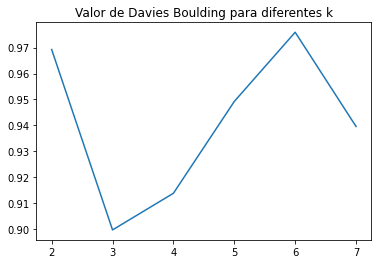

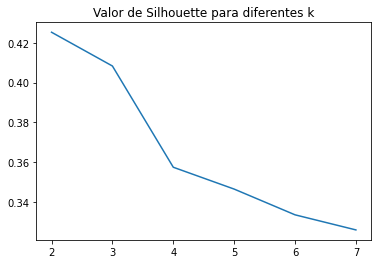

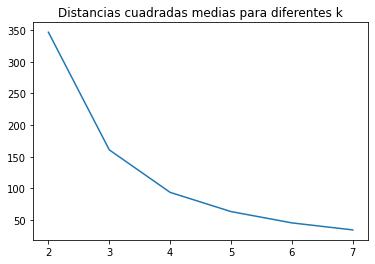

In [24]:
plt.plot(range(2, K_MAX), davies_boulding)
plt.title('Valor de Davies Boulding para diferentes k')
plt.show()

plt.plot(range(2, K_MAX), silhouette)
plt.title('Valor de Silhouette para diferentes k')
plt.show()

plt.plot(range(2, K_MAX), distances)
plt.title('Distancias cuadradas medias para diferentes k')
plt.show()

Si nos fijamos en los valores de Davies Boulding, vemos que el valor mínimo es 3 con bastante diferencia. Este valor indica la razón entre las distancias intra-cluster y las distancias inter-cluster. Cuanto menor sea este valor, mejor será el resultado, porque indicará que los clusters son más compactos y están más separados entre ellos.

Por definición, el valor de Silhouette varía de -1 a 1. Un valor cercano a 1 significa que el cluster es denso y está claramente separado del resto de clusters. Un valor más próximo a 0 indica solapamiento entre clusters, siendo el solapamiento mayor según más negativo sea el número (más cercano a -1). El cambio máximo en el diagrama del codo lo vemos en k=4, así que será mejor si la k es menor que 4.

Como conclusión, si juntamos estos dos resultados vemos que el mejor valor obtenido para la k del algoritmo k-means es 3. Es decir, que la agrupación óptima de los individuos es en 3 grupos.

## 5) Descripción de los clusters

Describe los clusters que has obtenido en el apartado anterior. Si te han salido más de 3, elige 3 de ellos que sean bastante diferentes entre sí. 

Para hacerlo estudia sus descriptores estadísticos y dales un sentido dentro del contexto del problema. ¿Qué perfil de préstamos quedan en cada cluster? Según dicho perfil, ¿qué cluster te parece que tendrá una mayor tasa de "default"? Corrobóralo calculando para cada cluster la proporción de préstamos que acabaron en "default".

Pinta el diagrama de dispersión en función de cada par de variables usando colores diferentes para cada cluster. ¿Qué clusters se separan mejor y en función de qué variables? ¿y cuáles se confunden más?

__Cuidado__: para poder interpretar correctamente los datos necesitas que estén en su escala original. Si decidiste escalar los datos, deberás ejecutar k-Means con los datos escalados pero asignar las etiquetas de clusters al conjunto de datos inicial. En este caso es muy sencillo porque el algoritmo no cambia el orden de los datos así que puedes crear directamente una nueva columna en el dataframe original con esas etiquetas. Puede que aparezca un SettingWithCopyWarning por asignar una nueva columna en un dataframe que es una vista de otro dataframe. Puedes ignorar este aviso o puedes hacer una copia del dataframe con `copy` para que no comparta memoria con el otro.

#### Solución:

A continuación queremos ver cuál es el conjunto de variables numéricas que mejor diferencian a los clusters. Recordemos que estamos estudiando las variables numéricas, y en este problema concretamente tenemos cuatro. 

In [25]:
# Crear una instancia del agrupador k-means
km = KMeans(init='random', n_clusters=3, random_state=333)

# Agrupar los puntos en clusters
km.fit(data_scaled)

# Podemos consultar el cluster asignado a cada punto y el centro de cada cluster
labels = km.labels_
centers = km.cluster_centers_

**Ingresos anuales en dólares de la persona que solicitó el préstamos según el cluster**

In [26]:
df['cluster'] = labels
df.groupby('cluster')["revenue"].describe(include=np.number).transpose()

cluster,0,1,2
count,3132.000,8030.000,2632.000
mean,131267.965,61853.178,72980.253
std,86811.327,27762.991,34788.986
min,35000.000,7000.000,9036.000
25%,85000.000,42000.000,50000.000
50%,110000.000,57000.000,65000.000
75%,150000.000,75174.000,90000.000
max,1650000.000,221000.000,300000.000


cluster
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
Name: revenue, dtype: object

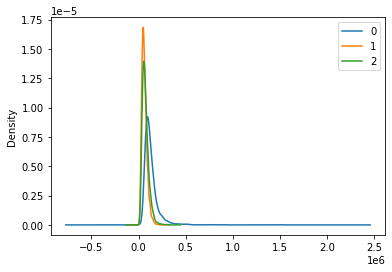

In [27]:
df.groupby(["cluster"])["revenue"].plot(kind="density", legend=True)

El cluster 0 agrupa a los solicitantes con mayores ingresos, y a priori parece el que menor tasa tendrá de `Default` tendrá (menos impagos), aunque esto no se puede garantizar solo viendo esta variable.

Los clusters 1 y 2 agrupa a los solicitantes con menos ingresos, muy a la par entre ellos debido a la media tan parecida que tienen teniendo en cuenta la diferencia que hay con respecto al cluster 0. Esto se debe a que la gran mayoría de personas está incluida en los clusters que reunen gente con ingresos más bajos.

**Porcentaje de endeudamiento sobre los ingresos anuales de la persona que solicitó el préstamo según el cluster**

In [28]:
df.groupby('cluster')["dti_n"].describe(include=np.number).transpose()

cluster,0,1,2
count,3132.000,8030.000,2632.000
mean,18.385,19.677,16.749
std,9.635,9.970,9.084
min,0.220,0.000,0.000
25%,12.160,12.940,10.027
50%,17.645,18.935,16.050
75%,23.885,25.540,22.523
max,190.870,182.810,87.850


cluster
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
Name: dti_n, dtype: object

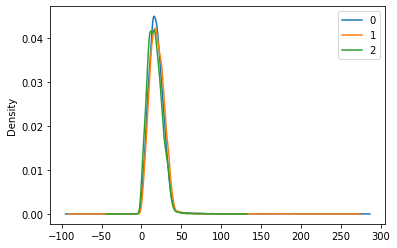

In [29]:
df.groupby(["cluster"])["dti_n"].plot(kind="density", legend=True)

No se observa ninguna diferencia significativa entre los clusters con respecto a esta variable. Tiene sentido que no haya gran diferencia porque, si recordamos la distribución de `dti_n` obtenida en el ejercicio 2, vemos que era la variable más uniformemente distribuida y que más próxima era a una distribución normal. Esto hace que la agrupación según el porcentaje de endeudamiento no conlleve una diferenciación clara entre los clusters.

**Indicador de solvencia de la persona que solicitó el préstamo según el cluster**

In [30]:
df.groupby('cluster')["fico_n"].describe(include=np.number).transpose()

cluster,0,1,2
count,3132.000,8030.000,2632.000
mean,698.406,683.057,748.906
std,26.479,16.047,27.587
min,662.000,662.000,707.000
25%,677.000,667.000,727.000
50%,697.000,682.000,742.000
75%,712.000,697.000,767.000
max,827.000,732.000,847.500


cluster
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
Name: fico_n, dtype: object

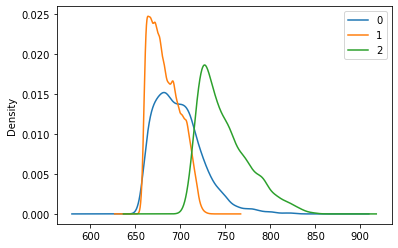

In [31]:
df.groupby(["cluster"])["fico_n"].plot(kind="density", legend=True)

Se puede observar que en el cluster 2 (verde) se agrupan los préstamos con un mayor índice de solvencia. Por ello, debería presentar una menor tasa `Default` (menos impagos).

En el cluster 0 (azul) y 1 (naranja) se agrupan prestamos con un índice de solvencia menor, siendo en el último donde hay una mayor concentración de los prestamos con el índice de solvencia más bajo.

**Cantidad de dinero solicitada según el cluster**

In [32]:
df.groupby('cluster')["loan_amnt"].describe(include=np.number).transpose()

cluster,0,1,2
count,3132.000,8030.000,2632.000
mean,27187.468,10318.739,12200.009
std,6393.773,5189.418,6864.603
min,5000.000,1000.000,1000.000
25%,23750.000,6000.000,6500.000
50%,27300.000,10000.000,11200.000
75%,32000.000,14600.000,16000.000
max,40000.000,25200.000,40000.000


cluster
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
Name: loan_amnt, dtype: object

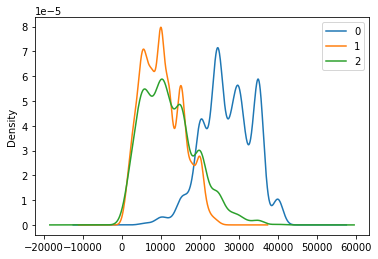

In [33]:
df.groupby(["cluster"])["loan_amnt"].plot(kind="density", legend=True)

Vemos que el cluster 0 agrupa los prestamos de una cantidad de dinero mayor.

Los clusters 1 y 2 agrupan préstamos de menor cantidad de dinero claramente, pero la distribución de la densidad vemos que es muy parecida en los 3. Teniendo en cuenta que además los clusters 1 y 2 se concentran en cantidades de dinero similares, podemos concluir que la gran mayoría de los préstamos se harán de bajas cantidades de dinero, siendo la moda la cantidad de 10.000€ aproximadamente ya que es donde coinciden los picos máximos de 2 de las densidades.

**Tasa de impagos según el cluster**

cluster
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Default, dtype: object

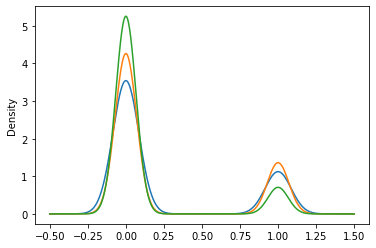

In [35]:
df["Default"] = df["Default"].astype('int32')
df.groupby(["cluster"])["Default"].plot(kind="density")

Sabemos y tenemos en mente que los diagramas de quesitos no suelen ser de mucha utilidad para analizar resultados debido a la dificultad que supone para el ojo humano diferenciar ángulos de uno a otro. Sin embargo, creemos que para analizar la variable categórica `Default` que indica la tasa de impagos, viene muy bien esta representación, ya que se ve muy claramente la diferencia de agrupar según un cluster u otros.

<AxesSubplot:ylabel='Default'>

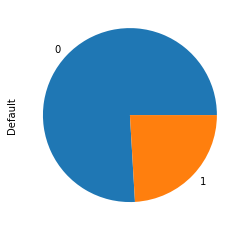

In [36]:
df[df['cluster'] == 0]['Default'].value_counts().plot.pie()

<AxesSubplot:ylabel='Default'>

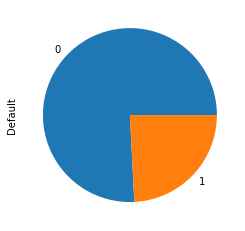

In [37]:
df[df['cluster'] == 1]['Default'].value_counts().plot.pie()

<AxesSubplot:ylabel='Default'>

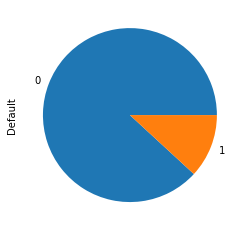

In [38]:
df[df['cluster'] == 2]['Default'].value_counts().plot.pie()

**Análisis:**

Las variables que menos conocimiento aportan son `revenue` y `dti_n` porque los resultados son muy similares entre sí. Esta similitud se puede apreciar muy bien en las gráficas 2 y 3. Sin embargo, es en estas 2 gráficas en las que mejor se diferencia la separación entre clusters, lo cual indica que las dos variables que mejor separan los clusters son `loan_amnt` y `fico`, ya que estando relacionadas entre sí la separación en clusters es la más clara de todas, da igual si la tercera variable es `revenue` o `dti_n`.

Para demostrar esto, vamos a dibujar el diagrama de dispersión de los clusters según esta especificación. Según nuestra teoría, la diferencia de agrupar según el conjunto de variables `loan_amnt`, `fico` y `cualquier_otra` será, con bastante diferencia con respecto a otras agrupaciones, la mejor forma de separar los clusters.

array([[<AxesSubplot:xlabel='loan_amnt', ylabel='loan_amnt'>,
        <AxesSubplot:xlabel='revenue', ylabel='loan_amnt'>,
        <AxesSubplot:xlabel='dti_n', ylabel='loan_amnt'>,
        <AxesSubplot:xlabel='fico_n', ylabel='loan_amnt'>],
       [<AxesSubplot:xlabel='loan_amnt', ylabel='revenue'>,
        <AxesSubplot:xlabel='revenue', ylabel='revenue'>,
        <AxesSubplot:xlabel='dti_n', ylabel='revenue'>,
        <AxesSubplot:xlabel='fico_n', ylabel='revenue'>],
       [<AxesSubplot:xlabel='loan_amnt', ylabel='dti_n'>,
        <AxesSubplot:xlabel='revenue', ylabel='dti_n'>,
        <AxesSubplot:xlabel='dti_n', ylabel='dti_n'>,
        <AxesSubplot:xlabel='fico_n', ylabel='dti_n'>],
       [<AxesSubplot:xlabel='loan_amnt', ylabel='fico_n'>,
        <AxesSubplot:xlabel='revenue', ylabel='fico_n'>,
        <AxesSubplot:xlabel='dti_n', ylabel='fico_n'>,
        <AxesSubplot:xlabel='fico_n', ylabel='fico_n'>]], dtype=object)

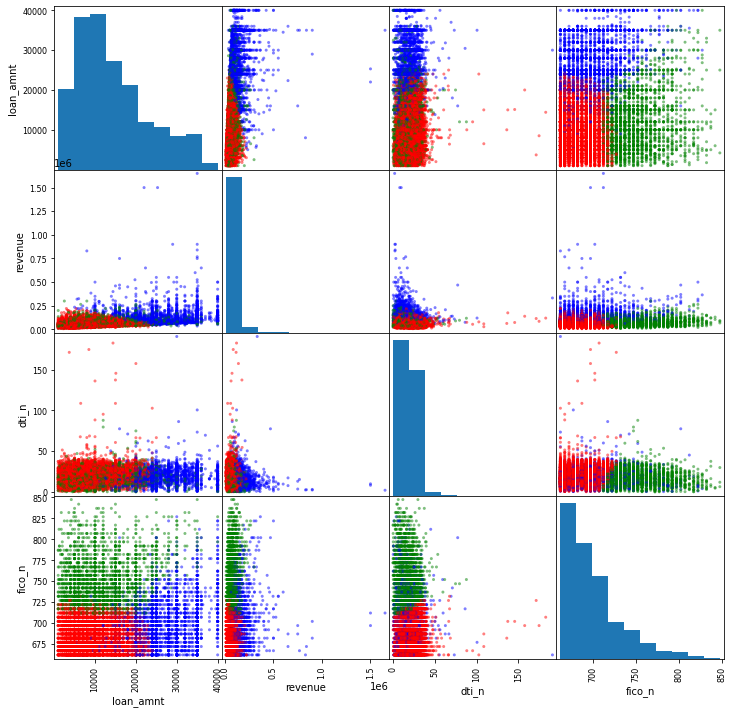

In [39]:
from pandas.plotting import scatter_matrix
%matplotlib inline

dic_colors = { 0: 'blue', 1: 'red', 2: 'green' }
colors = df['cluster'].map(dic_colors)

scatter_matrix(df_num, figsize = (12, 12), diagonal = 'hist', color=colors)

Como habíamos predicho anteriormente, la mejor agrupación en clusters es la que se guía principalmente por las variables `loan_amnt` y `fico_n` junto a cualquier otra, con bastante diferencia con respecto al resto de variables.

## Ejercicio 5 - Extra (añadido por alumnos)

La mejor forma de identificar los clusters más diferenciadores es viendo las representaciones a ojo, pero el ojo humano no es capaz de ver las cuatro dimensiones a la vez (recordemos, otra vez, que en este problema tenemos cuatro variables numéricas). Es por ello que vamos a usar representaciones en grupos de 3 variables, para ver cuál de ellos es el conjunto que mejor define al número de clusters óptimo obtenido en el ejercicio 4 (donde vimos que lo óptimo es usar 3 clusters).

Para que sea más visual y facilitar la lectura de los datos, hemos decidido utilizar unos planos interactivos en 3D para poder ver la distancia de los puntos en la tercera dimensión. Para poder hacer funcionar esto, será necesaria la instalación de la librería `ipympl`, que es una integración de Matplotlib para los Jupyter Notebook para hacer las gráficas interactivas. Para instalarla, bastará con abrir una terminal y escribir `pip3 install ipympl`.

**Nota:** Para hacer las gráficas interactivas será necesario ejecutar localmente las celdas de código que generan estas gráficas. En caso de no hacerlo, las gráficas aparecerán estáticas como una imagen (como un plot de Matplotlib normal), pero esto dificulta mucho la lectura de los datos, especialmente para el eje correspondiente a la profundidad en el plano (normalmente llamado `x` en los planos de 3 dimensiones).

In [40]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
'loan_amnt', 'revenue', 'dti_n', 'fico_n'

def plot_clusters(X, labels=None, centers=None):
    """ Función auxiliar para pintar los puntos de los clusters y, optativamente, sus centros.
    :param X: array de puntos de dos dimensiones (array de array de enteros)
    :param labels: cluster al que pertenece cada punto (array de enteros)
    :param centers: coordenadas de los centroides de los clusters (array de array de enteros)
    """
    
    colors = ['r','g','b','c','y','k','m',]
    # GRAFICA 1 - 'loan_amnt', 'revenue', 'dti_n'
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111, projection='3d')
    
    # Los dos primeros parámetros de la función scatter son las coordenadas de los puntos,
    # el parámetro 'c' indica la clase asignada de cada punto, y 'cmap' se usa para colorear 
    # las distintas clases
    ax1.scatter(X[:,0], X[:,1], X[:,2], c=labels, cmap=ListedColormap(colors))

    # Pintar los centroides de los clusters
    if centers is not None:
        ax1.scatter(centers[:,0], centers[:,1], centers[:,2], marker="x", color='k', s=150, linewidths = 5, zorder=10)
        
    plt.title("k-means con k=3 ('loan_amnt', 'revenue', 'dti_n')")
    ax1.set_xlabel('loan_amnt')
    ax1.set_ylabel('revenue')
    ax1.set_zlabel('dti_n')

    plt.show()
    
    # GRAFICA 2 - 'loan_amnt', 'revenue', 'fico_n'
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111, projection='3d')
    
    # Los dos primeros parámetros de la función scatter son las coordenadas de los puntos,
    # el parámetro 'c' indica la clase asignada de cada punto, y 'cmap' se usa para colorear 
    # las distintas clases
    ax2.scatter(X[:,0], X[:,1], X[:,3], c=labels, cmap=ListedColormap(colors))

    # Pintar los centroides de los clusters
    if centers is not None:
        ax2.scatter(centers[:,0], centers[:,1], centers[:,3], marker="x", color='k', s=150, linewidths = 5, zorder=10)
        
    plt.title("k-means con k=3 ('loan_amnt', 'revenue', 'fico_n')")
    ax2.set_xlabel('loan_amnt')
    ax2.set_ylabel('revenue')
    ax2.set_zlabel('fico_n')

    plt.show()
    
    # GRAFICA 3 - 'loan_amnt', 'dti_n', 'fico_n'
    fig3 = plt.figure()
    ax3 = fig3.add_subplot(111, projection='3d')
    
    # Los dos primeros parámetros de la función scatter son las coordenadas de los puntos,
    # el parámetro 'c' indica la clase asignada de cada punto, y 'cmap' se usa para colorear 
    # las distintas clases
    ax3.scatter(X[:,0], X[:,2], X[:,3], c=labels, cmap=ListedColormap(colors))

    # Pintar los centroides de los clusters
    if centers is not None:
        ax3.scatter(centers[:,0], centers[:,2], centers[:,3], marker="x", color='k', s=150, linewidths = 5, zorder=10)
        
    plt.title("k-means con k=3 ('loan_amnt', 'dti_n', 'fico_n')")
    ax3.set_xlabel('loan_amnt')
    ax3.set_ylabel('dti_n')
    ax3.set_zlabel('fico_n')

    plt.show()
    
    # GRAFICA 4 - 'revenue', 'dti_n', 'fico_n'
    fig4 = plt.figure()
    ax4 = fig4.add_subplot(111, projection='3d')
    
    # Los dos primeros parámetros de la función scatter son las coordenadas de los puntos,
    # el parámetro 'c' indica la clase asignada de cada punto, y 'cmap' se usa para colorear 
    # las distintas clases
    ax4.scatter(X[:,1], X[:,2], X[:,3], c=labels, cmap=ListedColormap(colors))

    # Pintar los centroides de los clusters
    if centers is not None:
        ax4.scatter(centers[:,1], centers[:,2], centers[:,3], marker="x", color='k', s=150, linewidths = 5, zorder=10)
        
    plt.title("k-means con k=3 ('revenue', 'dti_n', 'fico_n')")
    ax4.set_xlabel('revenue')
    ax4.set_ylabel('dti_n')
    ax4.set_zlabel('fico_n')

    plt.show()

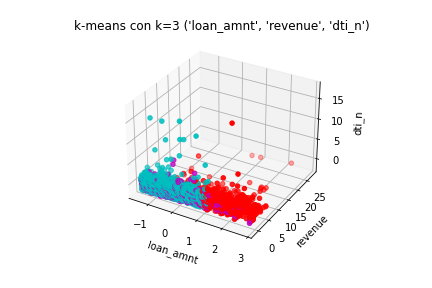

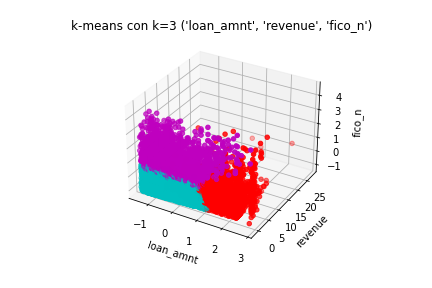

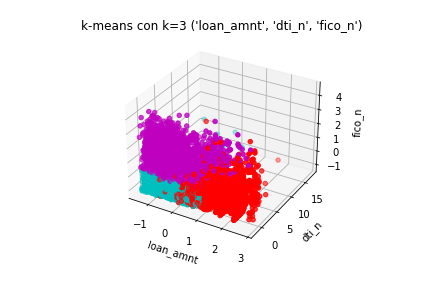

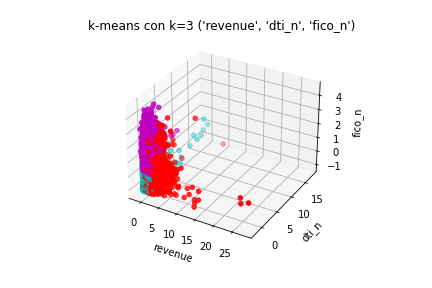

In [41]:
plot_clusters(data_scaled, labels)

Como podemos volver a ver en las gráficas obtenidas, los clusters que mejor separan los datos son aquellos que incluyen las variables `loan_amnt` junto a `fico_n`, sin notar una gran diferencia si la tercera variable es `revenue` o `dti_n`. Gracias a los planos interactivos nos podemos mover por los distintos ejes de las variables y ver que los clusters mencionados son, con mucha diferencia, los que mejor separaran a los clusters.

Con estos resultados concluimos esta parte de la gráfica, pudiendo decir que si quisiéramos agrupar los datos de préstamos contenidos en el archivo .csv dado, la mejor opción sería crear 3 clusters, y que 2 de las variables que los definan sean `loan_amnt` y `fico_n` junto a una tercera variable que no tendrá gran relevancia en el resultado.